In this file I prepare code for undersampling AF2 for actual k-space data (Rings); this will have to be transferred to matlab code.

**Strategy**

The strategy is as follows, I keep 15% of k-space data in the center of k-space (no undersampling, highest signal region).

Then I randomly delete  rings (except for the 20%) until I have a ~50% of data in k-space. For the next time step I do the same
but with the restriction that I take different random rings, to get a complementary pattern, etc.

In [1]:
import sys
import os

sys.path.append('../../../scripts')
sys.path.append('../../../models')

import copy
os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import loadmat
import random

from data_preparation import *
import plotly.graph_objects as gorings
import scipy.io as sio
from scipy.io import savemat

In the code below, I compute exactly how much percent of k-space is sampled at which k_z position

No handles with labels found to put in legend.


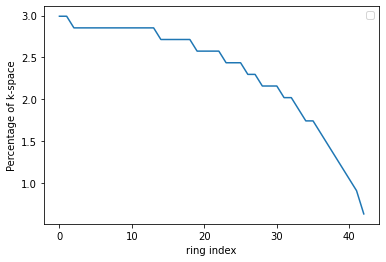

In [2]:
mat_data_8 = loadmat('../../fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')
csi_data = mat_data_8['csi']
Data = csi_data['Data'][0,0]

Par = csi_data['Par'][0,0]

Circles_Per_kz_Matrix = Par['AngIntsPerPartEnc'][0,0]

number_of_rings = Circles_Per_kz_Matrix.shape[1]

Circles_Per_ring = np.zeros(number_of_rings)

for i in range(0,number_of_rings):
    Circles_Per_ring[i] = np.sum(Circles_Per_kz_Matrix[:,i])

Percentage_Per_ring = 100*Circles_Per_ring / np.sum(Circles_Per_kz_Matrix)

plt.plot(Percentage_Per_ring)

# Add labels and title
plt.xlabel("ring index")
plt.ylabel("Percentage of k-space")

# Add a legend
plt.legend()

# Show the plot
plt.show()

Compute how many rings amount to ~20% of the data

In [3]:
x = 0

for i in range(0,4):
    x = x + Percentage_Per_ring[i]
    print('ring')
    print(i+1)

    
print(x)

ring
1
ring
2
ring
3
ring
4
11.691022964509393


In [4]:
#### Next I want to undersample in a complementary fashion. I generate a pool that has all indices that are not sampled 
#### except for ones that are always kept across time steps. 

def pool(kept_Indices, Number_Circles):
    all_indices = np.arange(Number_Circles)  # Generate array [0, 1, ..., Number_Circles-1]
    return np.delete(all_indices, kept_Indices)  # Remove indices in kept_Indices

In [5]:
fixed_ring_indices = list(range(0, 4))

Pool = pool(fixed_ring_indices, number_of_rings)

In [6]:
Pool

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42])

In [7]:
kspace_percentage = Percentage_Per_ring

#throw_away = 5

# target_percentage = 20

# #### Pool keeps track of which k_z indices have already been sampled; it contains the UNSAMPLED indices
# Pool = pool(fixed_ring_indices, number_of_rings)
# #Pool = Pool[throw_away:-throw_away] ## throw away top and bottom 5 k_z indices to save some k space time

# Pool_fixed = pool(fixed_ring_indices, number_of_rings)
# #Pool_fixed = Pool_fixed[5:-5]# this second pool never shrinks. If at a certain timesteps
# # it is not managed to draw from the normal Pool anymore (because percentage contributions are too high)
# #its still allowed to make 20 attempts from the fixed pool, to be able to sample even more



# ## make sure you cannot have more than 100 attempts to select planes
# dummy = 0 
# covered_percentage =  np.sum(kspace_percentage[fixed_ring_indices])   # ~29%

# Mask_ring_T = np.zeros((number_of_rings,8))
# #Extra_Attempt = 0## allow up to 20 times to sample even closer to desired AF  

# for T in range(0,8):
#     temp_mask = np.zeros_like(kspace_percentage, dtype=int)  ## 0 to 42, one index per k_z position
#     temp_mask[fixed_ring_indices] = 1  # always include fixed planes
    
#     dummy = 0
#     covered_percentage =  np.sum(kspace_percentage[fixed_ring_indices])   # ~29%
#     while dummy < 1000:
#         dummy = dummy +1
#         Extra_Attempt = 0

#         if len(Pool) == 0: # pool is refreshed if it is empty
#             Pool = pool(fixed_ring_indices, 43)
#             #Pool = Pool[throw_away:-throw_away]

#         kept_index = random.randint(0, len(Pool)-1)  # randomly select ring index to keep
#         additional_coverage = kspace_percentage[Pool[kept_index]] # this is how much percent of kspace this position covers
       
        
#         if covered_percentage + additional_coverage < target_percentage:
#             temp_mask[Pool[kept_index]] = 1
#             Pool = np.delete(Pool,kept_index)
#             covered_percentage = covered_percentage + additional_coverage
#         else:
#             while Extra_Attempt <10: # try to draw from fixed pool
#                 kept_index = random.randint(0, len(Pool_fixed)-1)
#                 additional_coverage = kspace_percentage[Pool_fixed[kept_index]]

#                 Extra_Attempt = Extra_Attempt +1

#                 if covered_percentage + additional_coverage < target_percentage and temp_mask[Pool_fixed[kept_index]] == 0:
#                     temp_mask[Pool_fixed[kept_index]] = 1
#                     covered_percentage = covered_percentage + additional_coverage

            
#     Mask_ring_T[:,T] = temp_mask

# for T in range(0,8):
#     print(np.sum(Mask_ring_T[:,T]*kspace_percentage))
    
# for T in range(0,8):
#     print(f'Sampled k_z Positions time step {T+1}:')
#     print(np.where(Mask_ring_T[:,T])[0])
    
# file_name = "Sampling_Patterns_Regular/Mask_AF5.npy"    

# # # Check if the file exists
# if os.path.exists(file_name):
#      print(f"File '{file_name}' already exists. Skipping save.")
        
# else:
# #     # Save the Mask array to .mat
#     np.save(file_name, Mask_ring_T)
#     print(f"File '{file_name}' saved successfully.")

Mask_ring_T = np.load("Sampling_Patterns_Regular/Mask_AF5.npy")

Mask_kz_T_Test = np.zeros((43))
for i in range(0,8):
    Mask_kz_T_Test = Mask_kz_T_Test + Mask_ring_T[:,i]
    
print(Mask_kz_T_Test)  ### if there are no 0s it means everything was sampled at least once

for T in range(0,8):
    print(f'Sampled k_z Positions time step {T+1}:')
    print(np.where(Mask_ring_T[:,T])[0])

np.where(Mask_kz_T_Test == 0)[0]
kspace_percentage[np.where(Mask_kz_T_Test == 0)[0]]
print("Total percent sampled over time:")
print(100-np.sum(kspace_percentage[np.where(Mask_kz_T_Test == 0)[0]]))

[8. 8. 8. 8. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 2. 1. 1. 2. 4.]
Sampled k_z Positions time step 1:
[ 0  1  2  3 10 18 23]
Sampled k_z Positions time step 2:
[ 0  1  2  3  9 14 19]
Sampled k_z Positions time step 3:
[ 0  1  2  3 16 21 29 42]
Sampled k_z Positions time step 4:
[ 0  1  2  3  7 12 38 42]
Sampled k_z Positions time step 5:
[ 0  1  2  3  4 28 38 40 41]
Sampled k_z Positions time step 6:
[ 0  1  2  3  5 22 30 42]
Sampled k_z Positions time step 7:
[ 0  1  2  3  8 31 33 41 42]
Sampled k_z Positions time step 8:
[ 0  1  2  3 20 26 32 39]
Total percent sampled over time:
72.30340988169797


**Reshaping**

The above code accomplishes that I have the complete k_space mask information in the format (ring, T). If Mask[i,j] = 1, it means ring index can be sampled at timestep T, otherwise not.

In [8]:
Mask_ring_T.shape

(43, 8)

Next, I actually save something to that structure. I start with the fully sampled case.

# ***Save to matlab file and numpy array***

In [9]:
Mask =  np.pad(Mask_ring_T, ((0, 1), (0, 0)), mode='constant', constant_values=0) #add another 0 for the 44th ring of P03

matlab_struct = {'Data': Mask}

savemat('csiUndersampled_AF5.mat', {'csiUS': matlab_struct})

# ***visualize undersampling pattern***

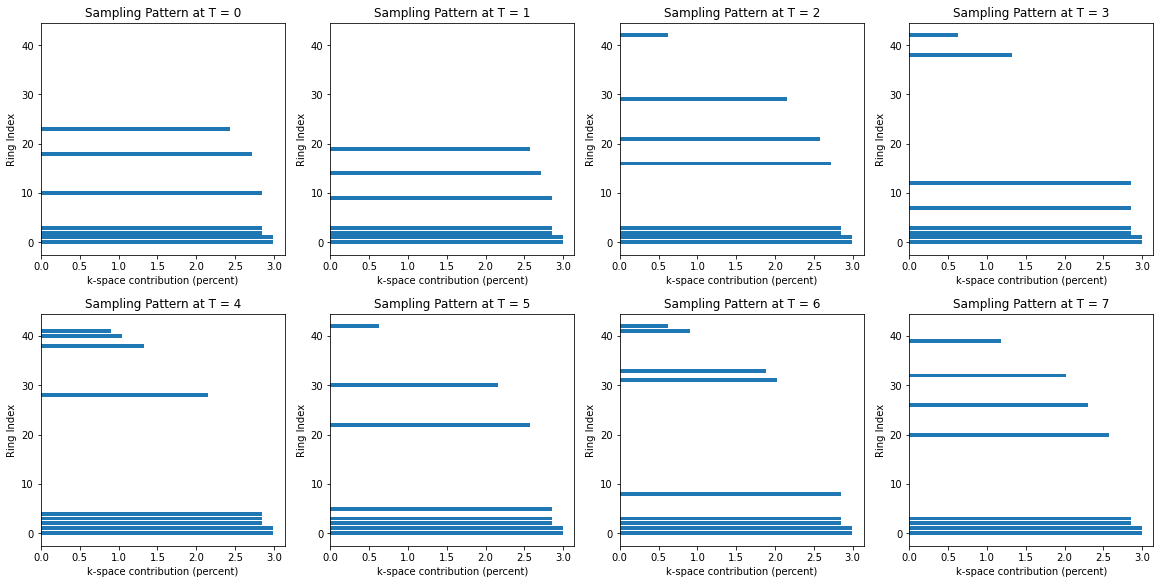

In [10]:
kspace_percentage

# X-Achse (Index der Einträge)


fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)

# Plot each subplot
for i, ax in enumerate(axes.flat):
    y = np.arange(len(kspace_percentage))  # Index positions for the bars
    ax.barh(y, kspace_percentage*Mask_ring_T[:,i])  # Create horizontal bar chart
    ax.set_title(f"Sampling Pattern at T = {i}")  # Set title for each subplot
    ax.set_ylabel("Ring Index")
    ax.set_xlabel("k-space contribution (percent)")

# Show the plot
plt.show()

# Diagramm anzeigen
plt.show()

**Reconstruction k-z Positions of Rings**

In [11]:
mat_data_4 = loadmat('../../fn_vb_DMI_CRT_P04/CombinedCSI_full_rank.mat')
csi_data = mat_data_4['csi']
par_data = csi_data['Par'][0,0]
Data_Size = par_data['DataSize'][0][0][0]
Data_Size

array([array([[526,   1,  43,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  43,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  41,   1,  96,   1,   8]], dtype=uint16),
       array([[526,   1,  39,   1,  96,   1,   8]], dtype=uint

In [12]:
Number_Of_Rings = 0
for i in range(0,43):
    Number_Of_Rings = Number_Of_Rings +Data_Size[i][0][2]
print('Total Number of Rings')
print(Number_Of_Rings)

print('Total Number of k-Space points')
print(Number_Of_Rings*526)

Total Number of Rings
1437
Total Number of k-Space points
755862


In [13]:
43*4

172

In [14]:
172/(1437)

0.11969380654140571